In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
import os.path 
import sncosmo

In [2]:
save_path = '/home/joao/Documentos/templates'

In [3]:
kernel = 10.0 * RBF(length_scale=20.0, length_scale_bounds=(5, 25)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

In [4]:
csp = sncosmo.get_magsystem('csp')
ab = sncosmo.get_magsystem('ab')
vega = sncosmo.get_magsystem('vega')

In [5]:
%run ./functions.ipynb

In [6]:
hist = []
t0_values = []

In [7]:
#file = open("names.txt")
#lines = file.readlines()
#file.close()

In [8]:
#training_set = []

In [9]:
#for line in lines:
#    if line.startswith('#'): continue
#    co=line.rstrip().replace('INDEF','Nan').split()

#    training_set.append(co[0])

In [10]:
sn_names=glob.glob("*.json")

In [11]:
len(sn_names)

378

In [12]:
maxvalues = []

In [13]:
sn_names = ["SN2001bf.json"]

In [14]:
list_data = []
lightc = []

In [15]:
for j in range(0,len(sn_names)):  
    
    name = sn_names[j]

    print(name)
    
    with open(name, "r") as read_file:
        data = json.load(read_file)

    url = name
    if url.endswith('.json'):
        url = url[:-5]

    redshift = redshift_value(data[url])
    
    if redshift is not None:

        t0 = max_time(data[url])
        #print(t0)
        mag = []
        time = []
        system = []

        for i in range(0,len(data[url]["photometry"])):

            if "band" in data[url]["photometry"][i]:

                if data[url]["photometry"][i]["band"] == "B":
                    
                    if "system" in data[url]["photometry"][i]:
                        
                        system.append(data[url]["photometry"][i]["system"])

                        mag.append(float(data[url]["photometry"][i]["magnitude"]))
                        time.append(float(data[url]["photometry"][i]["time"]))
                    
                    else:
                        
                        system.append("w")

                        mag.append(float(data[url]["photometry"][i]["magnitude"]))
                        time.append(float(data[url]["photometry"][i]["time"]))
        
        if len(time) > 3:
    
            #maxvalues.append(min(mag))
            
            ntime = []
            nmag = []
            for i in range(0,len(mag)):

                if np.abs(time[i]- min(time)) < 100:
                        
                    if system[i] == "CSP":
                        
                        nmag.append(csp.band_mag_to_flux(mag[i], 'cspb')*(1+redshift)**3)
                        ntime.append([time[i]])
                        
                    if system[i] == "AB":
                        #print("ab")
                        
                        nmag.append(ab.band_mag_to_flux(mag[i], 'cspb')*(1+redshift)**3)
                        ntime.append([time[i]])
                        
                    if system[i] == "Vega":
                        
                        #print("vega")
                        nmag.append(vega.band_mag_to_flux(mag[i], 'cspb')*(1+redshift)**3)
                        ntime.append([time[i]])   
                        
                    if system[i] == "w":
                        
                        #print("w")
                        nmag.append(vega.band_mag_to_flux(mag[i], 'cspb')*(1+redshift)**3)
                        ntime.append([time[i]])                     
                                      
                    #print(np.abs(time[i][0] - min(time[i])))                         
                
            if len(nmag) > 3:   
                
                gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(ntime, nmag)

                X_ = np.linspace(min(ntime)[0], max(ntime)[0], 1000)

                y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

                y_mean = list(y_mean)

                idx = y_mean.index(max(y_mean))

                if idx > 2: 
                    
                    maxvalues.append(max(y_mean))
                    
                    #if max(y_mean) < 0.5:
                    hist.append([X_[idx] - t0,sn_names[j]])
                    t0_values.append([X_[idx],sn_names[j]])

                    lightc.append([X_, y_mean])                    

                #list_data.append(max(y_mean))
                #list_data.append([X_, y_mean])

SN2001bf.json
0.015501


<IPython.core.display.Javascript object>


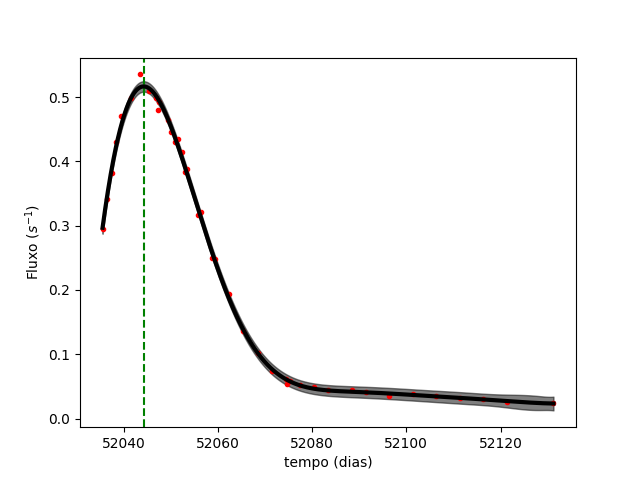

In [18]:
%matplotlib notebook
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
plt.plot(ntime, nmag, 'r.')
plt.xlabel('tempo (dias)')
plt.ylabel('Fluxo ($s^{-1}$)')
plt.axvline(x=t0_values[0][0], linestyle = '--', color = 'g')
plt.savefig('curvadeluzSN2001bf.png', format='png', dpi=600)
plt.show()

In [ ]:
#list_data_temp = []

In [ ]:
'''
for i in range(0,len(maxvalues)):
    
    if maxvalues[i]<25:
        
        list_data_temp.append(maxvalues[i])
'''

In [ ]:
system

In [ ]:
%matplotlib inline
plt.hist(maxvalues, bins=30)
#plt.xlim(0,30)
plt.show()

In [ ]:
max(maxvalues)

In [ ]:
len(lightc)

In [ ]:
%matplotlib notebook
for i in range(0,len(lightc)):
    
    plt.plot(lightc[i][0],lightc[i][1])
    
plt.show()

In [ ]:
hist_1 = []
for i in range(0,len(hist)):
    
    if np.abs(hist[i][0]) < 20:
        
        hist_1.append([hist[i][0], hist[i][1]])

In [ ]:
hist_val = []

In [ ]:
for i in range(0,len(hist_1)):
    
    hist_val.append(hist_1[i][0])

In [ ]:
%matplotlib notebook

plt.hist(hist_val, bins=30)
plt.ylabel('Probability')
plt.show()

In [ ]:
hist_1

In [ ]:
len(hist_1)

In [ ]:
names = []
zerotime = []

In [ ]:
for i in range(0,len(t0_values)):
    
    zerotime.append(t0_values[i][0])
    names.append(t0_values[i][1][:-5])

In [ ]:
names

In [ ]:

table = []
for l in range(0,len(names)):
    table.append((names[l],zerotime[l]))

name_of_file = "t0_values"

completeName = os.path.join(save_path, name_of_file+".txt")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [ ]:
%matplotlib notebook
plt.plot(time,mag,'.')
plt.show()

In [ ]:

table = []
for l in range(0,len(names)):
    table.append((names[l],maxvalues[l]))

name_of_file = "max_valuesB"

completeName = os.path.join(save_path, name_of_file+".txt")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [ ]:
maxvalues

In [ ]:
mag